# Assignment 3: Unsupervised Learning

In this assignment you will:
* Implement K-means clustering and use it for color-quantization of images
* Train a MoG model by implementing the EM algorithm. Compare to K-means on the same test data. 
* Use MoG for image segmentation

# Part 1: K-Means Clustering

## Setup

First import the required packages and do some setup:

In [1]:
from __future__ import print_function

import sys
sys.path.append('./assignment3')

import time
import imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import misc
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal
from assignment3 import kmeans, kmeans_colors, em_mog, em_segmentation

# Set default parameters for plots
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'jet'

%load_ext autoreload
%autoreload 2

Let's generate some test-data for you to test your implementation of the k-means and EM algorithm. Note that we generate gaussian blobs with non-isotropic covariance matrices. 

C:\Users\administrator\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:652: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


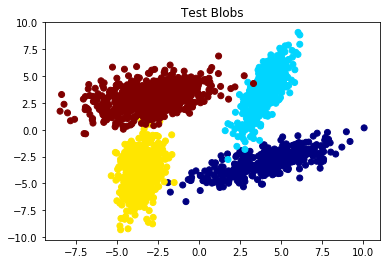

In [2]:
# Generate samples of 4 different gaussians
rv1 = multivariate_normal.rvs([4.0, -3.], [[4.0, 1.5], [1.5, 1.1]], size=400)
rv2 = multivariate_normal.rvs([4.0, 3.5], [[1.0, 2.3], [0.8, 2.75]], size=500)
rv3 = multivariate_normal.rvs([-3.5, -4.0], [[0.5, 1.0], [0.3, 3.]], size=600)
rv4 = multivariate_normal.rvs([-3., 3.], [[2.5, 0.1], [2.3, 1.5]], size=700)

# Concatenate the samples and create corresponding labels
X = np.concatenate([rv1, rv2, rv3, rv4], 0)
y = np.array([0]*400+[1]*500+[2]*600+[3]*700)

# Plot the test data
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Test Blobs")
plt.show()

## Exercise 1: K-Means Clustering [15 Points]

You will now implement the standard k-means clustering algorithm and test it on the generated test data. 

**TODO**: Implement the k-means clustering algorithm in ***kmeans.py*** accroding to specs and test your implementation with the provided test data.


Number of iterations: 4, Execution time: 0.1545724868774414s


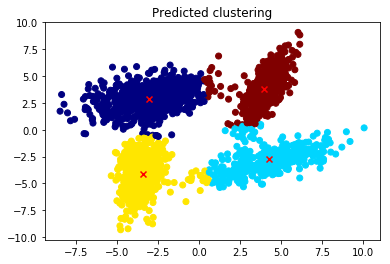

In [3]:
# Test your implementation
centers, assign = kmeans(X, 4)
plt.clf()
plt.scatter(X[:, 0], X[:, 1], c=assign)
plt.scatter(centers[:, 0], centers[:, 1], c='r', marker='x')
plt.title("Predicted clustering")
plt.show()

## Exercise 2: Questions about K-means [10 Points]

* Does k-means always result in the same clustering? Why?

***Your Answer:***

No. As we are always starting with different cluster centers, there is a change to not always find the same local minima.

* Would you expect K-means to work better in the case of data generated from isotropic gaussian distributions? Why?

***Your Answer:***

Yes, as one of the assumptions of k-means is that we have clusters of circular shape and with isotropic gaussian distribution this is the case. So if this assumption is met, this should lead to better results.

## Exercise 3: Using k-means for image compression [10 Points]

You will now use K-means to cluster pixel values of an image and use the cluster assignments as a way to quantize/compress the color-space of the image. Replace each pixel with the mean of the assigned cluster.
You should use the implementation provided through sklearn in this exercise ([sklearn.cluster.KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)).

Feel free to test the algorithm on your own images and with different number of clusters.

**TODO**: Implement the color-quantization through k-means in ***kmeans_colors.py*** according to specs. 


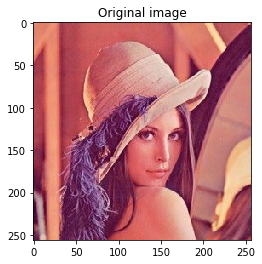

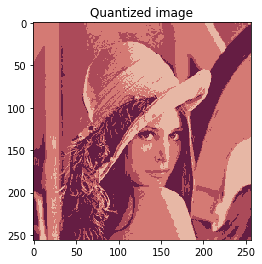

In [4]:
# Load and show test image
img = imageio.imread('lena.jpg')
plt.imshow(img)
plt.title("Original image")
plt.show()

# Compute quantized image
k = 4
img_cl = kmeans_colors(img, k)

# Show the quantized image
plt.imshow(img_cl)
plt.title("Quantized image")
plt.show()

# Part 2: Expectation Maximization

In the second part of the assignment you will implement the EM algorithm for Mixture of Gaussian (MoG) models. You will then use this model on the problem of image-segmentation.


## Exercise 4: EM for MoG [25 Points]

**TODO:** Implement the **EM** algorithm for Mixture of Gaussian models in **em_mog.py** according to specs. Test your implementation on the provided test data.  

Iter: 1/20, LL: -11135.037033908162
Iter: 2/20, LL: -11250.182119068875
EM has converged...
Number of iterations: 2, Execution time: 5.453707933425903s


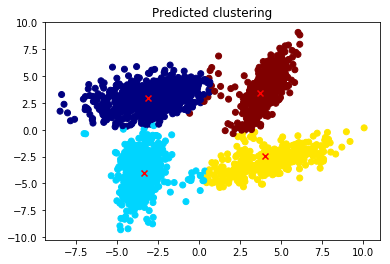

In [5]:
# Test your implementation
phi, mu, sigma, w = em_mog(X, 4)
plt.clf()
plt.scatter(X[:, 0], X[:, 1], c=np.argmax(w, 1))
plt.scatter(mu[:, 0], mu[:, 1], c='r', marker='x')
plt.title("Predicted clustering")
plt.show()

## Exercise 5: Estimating Clustering Quality: K-Means VS RM [15 Points]

Compare cluster assignment that you get with K-Means and EM algorithm. In order to do so you need to first implement Normalized Mutual Information Score defined as follows:

\begin{equation}
N M I(Y, C)=\frac{2 \times I(Y ; C)}{[H(Y)+H(C)]}
\end{equation}

where 
* Y is a class label
* C is a cluster label
* H(Y) is Entropy of class labels 
* H(C) is Entropy of cluster labels 
* I(Y ; C) is a mutual information

<span style="color:red">You are not allowed to use function sklearn.metrics.normalized_mutual_info_score!</span>
<span style="color:red">You can use following functions to complete the code:</span>
* sklearn.metrics.mutual_info_score
* scipy.stats.entropy

As a test case try to run the following code:
<span style="color:red">print(normalized_mutual_info_score(np.array([3,2,1,0]), np.array([0,1,2,3])))</span>

The results of this code must be 1.0

In [6]:
import seaborn as sns; sns.set()
from scipy.stats import mode, entropy
from sklearn.metrics import accuracy_score, mutual_info_score, confusion_matrix
from sklearn.metrics.cluster import contingency_matrix
from scipy.stats import multivariate_normal

def ent(labels):
    """Calculates the entropy for a labeling.

    Parameters
    ----------
    labels : int array, shape = [n_samples]
    The labels

    Notes
    -----
    The logarithm used is the natural logarithm (base-e).
    """
    if len(labels) == 0:
        return 1.0
    label_idx = np.unique(labels, return_inverse=True)[1]
    pi = np.bincount(label_idx).astype(np.float64)
    pi = pi[pi > 0]
    pi_sum = np.sum(pi)

    return -np.sum((pi / pi_sum) * (np.log(pi) - np.log(pi_sum)))


def normalized_mutual_info_score(x1,x2):
    """
    Computes Normalized Mutual Information Score between x1 and x2.

    Args:
        x1: Ground-Truth Labels
        x2: Predicted Clusters

    Returns:
        nmis: Normalized Mutual Information Score between x1 and x2

    """
    nmis = None
    
    #######################################################################
    # TODO:                                                               #
    # Compute Normalized Mutual Information Score between x1 and x2        #
    #                                                                     #
    #######################################################################

    classes = np.unique(x1)
    clusters = np.unique(x2)

    if (classes.shape[0] == clusters.shape[0] == 1 or
            classes.shape[0] == clusters.shape[0] == 0):
        return 1.0
    
    contingency = contingency_matrix(x1, x2)
    contingency = contingency.astype(np.float64, **{'copy': False})

    mi = mutual_info_score(x1, x2, contingency=contingency)
    h_true, h_pred = ent(x1), ent(x2)
    normalizer = np.mean([h_true, h_pred])
    nmis = mi / normalizer

    #######################################################################
    #                         END OF YOUR CODE                            #
    #######################################################################
    
    return nmis

methods = ['kmeans','em']

N = 4

# Generate samples of 4 different gaussians
rv1 = multivariate_normal.rvs([4.0, -3.], [[4.0, 1.5], [1.5, 1.1]], size=400)
rv2 = multivariate_normal.rvs([4.0, 3.5], [[1.0, 2.3], [0.8, 2.75]], size=500)
rv3 = multivariate_normal.rvs([-3.5, -4.0], [[0.5, 1.0], [0.3, 3.]], size=600)
rv4 = multivariate_normal.rvs([-3., 3.], [[2.5, 0.1], [2.3, 1.5]], size=700)

# Concatenate the samples and create corresponding labels
X = np.concatenate([rv1, rv2, rv3, rv4], 0)
y = np.array([0]*400+[1]*500+[2]*600+[3]*700)

for method in methods:
    if method == 'kmeans':
        centers, assign = kmeans(X, N)
    elif method == 'em':
        phi, mu, sigma, w = em_mog(X, N)
        assign = np.argmax(w,axis=1)
    
    print('Normalized Mutual Information Score for %s=%.2f' % (method,normalized_mutual_info_score(y, assign)))
    print(normalized_mutual_info_score(np.array([3,2,1,0]), np.array([0,1,2,3])))


C:\Users\administrator\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:652: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


Number of iterations: 4, Execution time: 0.15604591369628906s
Normalized Mutual Information Score for kmeans=0.88
1.0
Iter: 1/20, LL: -10829.370676185283
Iter: 2/20, LL: -10791.75322893579
Iter: 3/20, LL: -10841.271666976883
EM has converged...
Number of iterations: 3, Execution time: 8.547732591629028s
Normalized Mutual Information Score for em=0.91
1.0



## Exercise 6: Questions about MoG [10 Points]

* Does the MoG model perform better on the provided test data? Why?

***Your Answer:***

Yes because each of the data groups has a rather ellipsoidal shape which the MoG model can account for. Also, the MoG model allows clusters to overlap, which K-means does not.

* What are advantages and disantages of MoG vs. K-means?

***Your Answer:***


* K-means is easy to understand and to implement, but it assumes that the clusters are spherical and is less efficient with data of the more complex shape.
* Also, K-means are using a hard assignment that can lead to misclassification (no cluster overlap). 
* MoG, on the other hand, uses a soft cluster assignment, which makes it better to deal with overlapping clusters. It doesn't assume a particular shape for the clusters and is, therefore, more flexible regarding cluster shape. 
* The algorithm is less intuitive to understand than K-means.


## Exercise 7: Image Segmentation with MoG [15 Points]

Image segmentation is the process of partitioning an image into multiple segments. The goal of segmentation is to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze.

In this exercise you will implement image segmentation by fitting a MoG model via EM. For this you will not only cluster the pixel colors (RGB) but extend the pixel features with their 2D coordinates. Hence, the clustered pixel features are of the form RGBXY. This allows for additional locality of the segments.

You should use the implementation provided through sklearn in this exercise ([sklearn.mixture.GaussianMixture](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)).

Feel free to test the algorithm on your own images and with different number of segments.

**TODO:** Implement the image-segmentation in ***em_segmentation.py*** according to specs.  

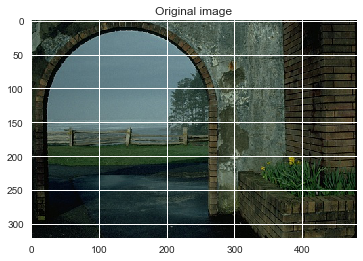

C:\Users\administrator\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


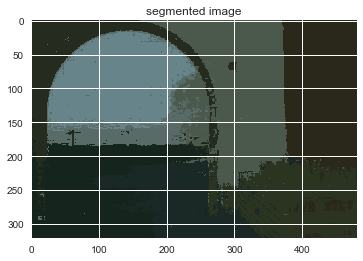

In [7]:
# Load and show test image
img = imageio.imread('test.jpg')
plt.imshow(img)
plt.title("Original image")
plt.show()

# Compute segmented image
img_seg = em_segmentation(img, 8)
plt.imshow(img_seg)
plt.title("segmented image")
plt.show()